# Data Preparation

In [ ]:
# Install necessary dependencies
!pip install nltk pandas tqdm requests

import os
import json
import pandas as pd
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Define dataset URL and paths
ZIP_URL = "https://zenodo.org/records/14891299/files/pan25-multi-author-analysis.zip?download=1"
ZIP_PATH = "pan25-multi-author-analysis.zip"
EXTRACT_FOLDER = "pan25_data"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Download the ZIP file
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(save_path, "wb") as file, tqdm(
        desc="Downloading Dataset",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
            bar.update(len(chunk))

# Unzip the dataset
def unzip_file(zip_path, extract_folder):
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Extracted to {extract_folder}")

# Download and unzip dataset
download_file(ZIP_URL, ZIP_PATH)
unzip_file(ZIP_PATH, EXTRACT_FOLDER)

# Define the root directory where the extracted folders exist
DATASET_ROOT = Path(EXTRACT_FOLDER)

# Define dataset splits
SPLITS = ["train", "validation"]
DIFFICULTY_LEVELS = ["easy", "medium", "hard"]

# Read and process the dataset
def read_problem_data(problem_file):
    text_path = problem_file
    json_path = text_path.with_name(f"truth-{text_path.stem}.json")

    # Read text
    with open(text_path, "r", encoding="utf-8") as f:
        text = f.read().strip()

    # Read labels
    with open(json_path, "r", encoding="utf-8") as f:
        truth = json.load(f)

    return text, truth["changes"]

Extracted to pan25_data


In [ ]:
# Define the file path
file_path = "pan25_data/hard/train/problem-3207.txt"

# New content to write
new_content = """Intelligence agencies aren't spying about pandemics folks.
The world has many interacting medical based organizations that monitor pandemics all the time.
Looking to the DoD or CIA or any other intelligence org to be the source of pandemic intelligence other than from a defense angle is a not their primary role.
Again, by rule, the NCMI is the lead agency on pandemic intelligence for the United States.
It's not an exception.
Additionally, the NCMI doesn't solely view medical intelligence from the lens of a "defense angle" as you believe.
But regardless, my comment originally rebutted your comment "Intelligence agencies aren't spying about pandemics folks."
Yes it does.
It's called the NCMI.
a.
There will be a unified Defense community for medical intelligence activities; those activities will be executed in a coordinated and coherent manner to effectively respond to U.S. intelligence priorities in support of national security objectives, and in accordance with all applicable laws, Presidential directives, DoD issuances, and Director of National Intelligence (DNI) guidelines.
From multiple angles; not solely based on a defense posture.
Where's your DOD policy citation that it's solely for defense posture?
"""

# Overwrite the file
with open(file_path, "w", encoding="utf-8") as f:
    f.write(new_content)

print(f"Successfully updated {file_path}")


Successfully updated pan25_data/hard/train/problem-3207.txt


In [ ]:
def process_dataset(split):
    dataset = []
    total_mismatched_pairs = 0  # Counter for total mismatched pairs

    for difficulty in DIFFICULTY_LEVELS:
        print(f"Processing {split} set - {difficulty} difficulty...")
        folder_path = DATASET_ROOT / difficulty / split

        for problem_file in tqdm(folder_path.glob("problem-*.txt")):
            with open(problem_file, "r", encoding="utf-8") as f:
                lines = f.readlines()

            # Strip whitespace and remove empty lines
            sentences = [line.strip() for line in lines if line.strip()]

            # Read corresponding labels
            _, labels = read_problem_data(problem_file)

            # Check for label mismatch
            if len(labels) != len(sentences) - 1:
                mismatch_count = abs(len(labels) - (len(sentences) - 1))
                total_mismatched_pairs += mismatch_count

                print(f"\n Label mismatch in {problem_file}")
                print(f" Total Sentences (Lines): {len(sentences)} | Expected Labels: {len(labels)}")
                print(f" Mismatched Pairs in This File: {mismatch_count}")

                # Print mismatched sentence-label pairs
                print("\n--- Mismatched Sentence Pairs ---")
                for i in range(min(len(sentences) - 1, len(labels), 5)):
                    print(f"[{i}] {sentences[i]} || {sentences[i+1]} --> Label: {labels[i]}")

                print("--- End of Mismatch ---\n")
                continue

            # Merge consecutive sentences for training
            for i in range(len(sentences) - 1):
                dataset.append({
                    "difficulty": difficulty,
                    "split": split,
                    "problem_id": problem_file.stem,
                    "sentence1": sentences[i],
                    "sentence2": sentences[i + 1],
                    "label": labels[i]
                })

    print(f"\n Total Mismatched Sentence-Label Pairs Across All Files: {total_mismatched_pairs}")
    return dataset
# Process both training and validation sets
train_data = process_dataset("train")
valid_data = process_dataset("validation")

# Convert to DataFrame and save as CSV
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

train_df.to_csv("train_dataset.csv", index=False)
valid_df.to_csv("valid_dataset.csv", index=False)

print("Training and validation datasets saved successfully!")

Processing train set - easy difficulty...


4200it [00:00, 5020.59it/s]


Processing train set - medium difficulty...


4200it [00:01, 3935.14it/s]


Processing train set - hard difficulty...


4200it [00:00, 5497.66it/s]



 Total Mismatched Sentence-Label Pairs Across All Files: 0
Processing validation set - easy difficulty...


900it [00:00, 6868.03it/s]


Processing validation set - medium difficulty...


900it [00:00, 6881.06it/s]


Processing validation set - hard difficulty...


900it [00:00, 7030.03it/s]



 Total Mismatched Sentence-Label Pairs Across All Files: 0
Training and validation datasets saved successfully!


In [ ]:
# Load processed datasets
train_df = pd.read_csv("train_dataset.csv")
valid_df = pd.read_csv("valid_dataset.csv")

# Show unique label counts
print("\n Label Distribution in Training Set:")
print(train_df['label'].value_counts())

print("\n Label Distribution in Validation Set:")
print(valid_df['label'].value_counts())


 Label Distribution in Training Set:
label
0    126738
1     31542
Name: count, dtype: int64

 Label Distribution in Validation Set:
label
0    26797
1     6857
Name: count, dtype: int64


# Feature Extraction

In [ ]:
import spacy
import textstat
import numpy as np
from collections import Counter

# Load SpaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Feature extraction function
def extract_features(text):
    doc = nlp(text)

    # Lexical Features
    word_lengths = [len(token.text) for token in doc if token.is_alpha]
    avg_word_length = np.mean(word_lengths) if word_lengths else 0

    function_words = set(["the", "is", "and", "but", "or", "because", "as", "that"])
    function_word_count = sum(1 for token in doc if token.text.lower() in function_words)

    # Syntactic Features
    pos_counts = Counter(token.pos_ for token in doc)
    num_nouns = pos_counts.get("NOUN", 0)
    num_verbs = pos_counts.get("VERB", 0)

    sentence_lengths = [len(sent.text.split()) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0

    # Stylometric Features
    punctuation_count = sum(1 for token in text if token in ".,!?;:-")
    readability_score = textstat.flesch_reading_ease(text)

    return [
        avg_word_length, function_word_count, num_nouns, num_verbs,
        avg_sentence_length, punctuation_count, readability_score
    ]

# Apply feature extraction to dataset
train_df["features1"] = train_df["sentence1"].apply(extract_features)
train_df["features2"] = train_df["sentence2"].apply(extract_features)
valid_df["features1"] = valid_df["sentence1"].apply(extract_features)
valid_df["features2"] = valid_df["sentence2"].apply(extract_features)

print(" Feature extraction completed!")


 Feature extraction completed!


In [ ]:
import pickle

# Save extracted features along with dataset
train_df.to_csv("train_features.csv", index=False)
valid_df.to_csv("valid_features.csv", index=False)

# Save as Pickle for faster loading
with open("train_features.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("valid_features.pkl", "wb") as f:
    pickle.dump(valid_df, f)

from google.colab import drive
drive.mount('/content/drive')
train_df.to_pickle("/content/drive/My Drive/train_features.pkl")
valid_df.to_pickle("/content/drive/My Drive/valid_features.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model Enhenced

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.01  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


Epoch 1/3:
Total Loss: 0.5162
Classification Loss: 0.4059
Orthogonality Loss: 0.0005
Feature Alignment Loss: 0.1103


Epoch 2/3:
Total Loss: 0.2843
Classification Loss: 0.2431
Orthogonality Loss: 0.0003
Feature Alignment Loss: 0.0412


Epoch 3/3:
Total Loss: 0.2307
Classification Loss: 0.2004
Orthogonality Loss: 0.0003
Feature Alignment Loss: 0.0303



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
# Evaluate on validation set
valid_acc, valid_f1 = evaluate_model_batched(model, valid_df, dataset_name="Validation")

Validation Set - Accuracy: 0.8979, Macro F1-Score: 0.8395


In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9468, Macro F1-Score: 0.9224
Medium Validation Set - Accuracy: 0.8845, Macro F1-Score: 0.8134
Hard Validation Set - Accuracy: 0.8668, Macro F1-Score: 0.7808


# Official Evaluator

In [ ]:
import requests
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in your Drive
save_path = "/content/drive/My Drive/evaluator.py"

# GitHub raw URL of the evaluator script
url = "https://raw.githubusercontent.com/pan-webis-de/pan-code/master/clef25/multi-author-analysis/evaluator/evaluator.py"

# Download and save
response = requests.get(url)
with open(save_path, "w") as f:
    f.write(response.text)

print("evaluator.py saved to:", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
evaluator.py saved to: /content/drive/My Drive/evaluator.py


In [ ]:
import os
import requests
import zipfile

url = "https://zenodo.org/records/14891299/files/pan25-multi-author-analysis.zip?download=1"
zip_path = "/content/drive/My Drive/pan25.zip"
extract_path = "/content/drive/My Drive/pan25_data"

print("Downloading PAN25 dataset...")
r = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(r.content)

print("Unzipping...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to", extract_path)
os.listdir(extract_path)


Unzipping...
Extracted to /content/drive/My Drive/pan25_data


['easy', 'hard', 'medium']

In [ ]:
import os
import json
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import spacy
import textstat
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from google.colab import drive

drive.mount('/content/drive')

# Load handcrafted features
with open("/content/drive/My Drive/train_features.pkl", "rb") as f:
    train_df = pickle.load(f)

with open("/content/drive/My Drive/valid_features.pkl", "rb") as f:
    valid_df = pickle.load(f)

# Load tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load SpaCy for feature extraction
nlp = spacy.load("en_core_web_sm")

#HANDCRAFTED FEATURE FUNCTION
def extract_features(text):
    doc = nlp(text)
    word_lengths = [len(token.text) for token in doc if token.is_alpha]
    avg_word_length = np.mean(word_lengths) if word_lengths else 0
    function_words = {"the", "is", "and", "but", "or", "because", "as", "that"}
    function_word_count = sum(1 for token in doc if token.text.lower() in function_words)
    pos_counts = Counter(token.pos_ for token in doc)
    num_nouns = pos_counts.get("NOUN", 0)
    num_verbs = pos_counts.get("VERB", 0)
    sentence_lengths = [len(sent.text.split()) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0
    punctuation_count = sum(1 for token in text if token in ".,!?;:-")
    readability_score = textstat.flesch_reading_ease(text)
    return [avg_word_length, function_word_count, num_nouns, num_verbs,
            avg_sentence_length, punctuation_count, readability_score]

#MODEL DEFINITION
import torch.nn as nn
import torch.nn.functional as F

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)
        self.classifier = nn.Linear(style_dim * 2, 1)
        self.ortho_lambda = 0.01

    def forward(self, input_ids, attention_mask, features1, features2):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        content_embedding = self.content_proj(embeddings)
        style_embedding = self.style_proj(embeddings)
        combined_features = torch.cat([features1, features2], dim=-1)
        feature_embedding = self.feature_proj(combined_features)
        style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
        content_weight = 1 - style_weight
        content_embedding = content_embedding * content_weight
        style_embedding = style_embedding * style_weight
        content_norm = F.normalize(content_embedding, dim=-1)
        style_norm = F.normalize(style_embedding, dim=-1)
        ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2
        style_feature_loss = 1 - F.cosine_similarity(style_norm, F.normalize(feature_embedding, dim=-1)).mean()
        combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
        logits = self.classifier(combined_rep).squeeze(-1)
        return logits, ortho_loss, style_feature_loss

#LOAD TRAINED MODEL
model = FactorizedAttentionModel().to("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("/content/drive/My Drive/enhenced_factorized_attention_model.pt", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded.")

#PREDICTION + JSON OUTPUT
def predict_and_save(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for file_name in tqdm(sorted(os.listdir(input_folder))):
        if not file_name.startswith("problem-") or not file_name.endswith(".txt"): continue
        problem_id = file_name[8:-4]
        with open(os.path.join(input_folder, file_name), "r") as f:
            sentences = [line.strip() for line in f if line.strip()]

        changes = []
        for i in range(len(sentences) - 1):
            sent1, sent2 = sentences[i], sentences[i + 1]
            encoding = tokenizer(sent1, sent2, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            f1 = torch.tensor([extract_features(sent1)], dtype=torch.float32).to(device)
            f2 = torch.tensor([extract_features(sent2)], dtype=torch.float32).to(device)
            logits, _, _ = model(encoding["input_ids"], encoding["attention_mask"], f1, f2)
            pred = torch.sigmoid(logits).item() > 0.5
            changes.append(int(pred))

        out_path = os.path.join(output_folder, f"solution-problem-{problem_id}.json")
        with open(out_path, "w") as f:
            json.dump({"changes": changes}, f, indent=2)

    print(f"Predictions saved to: {output_folder}")

predict_and_save("/content/drive/My Drive/pan25_data/easy/validation", "/content/drive/My Drive/pan25_output/easy")
predict_and_save("/content/drive/My Drive/pan25_data/medium/validation", "/content/drive/My Drive/pan25_output/medium")
predict_and_save("/content/drive/My Drive/pan25_data/hard/validation", "/content/drive/My Drive/pan25_output/hard")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Model loaded.


100%|██████████| 1800/1800 [08:29<00:00,  3.53it/s]


Predictions saved to: /content/drive/My Drive/pan25_output/easy


100%|██████████| 1800/1800 [10:30<00:00,  2.85it/s]


Predictions saved to: /content/drive/My Drive/pan25_output/medium


100%|██████████| 1800/1800 [08:50<00:00,  3.39it/s]

Predictions saved to: /content/drive/My Drive/pan25_output/hard


In [ ]:
import shutil

os.makedirs("/content/drive/My Drive/eval_result", exist_ok=True)

src_dir = "/content/drive/My Drive/pan25_data/easy/validation"
dest_dir = "/content/drive/My Drive/pan25_data/easy"

for filename in os.listdir(src_dir):
    if filename.startswith("truth-problem-"):
        shutil.move(
            os.path.join(src_dir, filename),
            os.path.join(dest_dir, filename)
        )

src_dir = "/content/drive/My Drive/pan25_data/medium/validation"
dest_dir = "/content/drive/My Drive/pan25_data/medium"

for filename in os.listdir(src_dir):
    if filename.startswith("truth-problem-"):
        shutil.move(
            os.path.join(src_dir, filename),
            os.path.join(dest_dir, filename)
        )

src_dir = "/content/drive/My Drive/pan25_data/hard/validation"
dest_dir = "/content/drive/My Drive/pan25_data/hard"

for filename in os.listdir(src_dir):
    if filename.startswith("truth-problem-"):
        shutil.move(
            os.path.join(src_dir, filename),
            os.path.join(dest_dir, filename)
        )

In [ ]:
!python "/content/drive/My Drive/evaluator.py" \
  --predictions "/content/drive/My Drive/pan25_output" \
  --truth "/content/drive/My Drive/pan25_data" \
  --output "/content/drive/My Drive/eval_result"

measure{
  key: "task1_f1_score"
  value: "0.9223944107339056"
}

measure{
  key: "task2_f1_score"
  value: "0.8134396580142804"
}

measure{
  key: "task3_f1_score"
  value: "0.78082967117158"
}



# Tuning ortho_lambda = 0.1

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

KeyboardInterrupt: 

In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model0.1.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model0.1.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model0.1.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9336, Macro F1-Score: 0.9034
Medium Validation Set - Accuracy: 0.8837, Macro F1-Score: 0.8208
Hard Validation Set - Accuracy: 0.8592, Macro F1-Score: 0.7904


# Tuning ortho_lambda = 1

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)


Epoch 1/3:
Total Loss: 0.4530
Classification Loss: 0.3486
Orthogonality Loss: 0.0012
Feature Alignment Loss: 0.1032


Epoch 2/3:
Total Loss: 0.3021
Classification Loss: 0.2622
Orthogonality Loss: 0.0007
Feature Alignment Loss: 0.0392


Epoch 3/3:
Total Loss: 0.2528
Classification Loss: 0.2244
Orthogonality Loss: 0.0009
Feature Alignment Loss: 0.0275



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model1.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model1.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model1.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9551, Macro F1-Score: 0.9341
Medium Validation Set - Accuracy: 0.8852, Macro F1-Score: 0.8069
Hard Validation Set - Accuracy: 0.8711, Macro F1-Score: 0.7719


# Tuning alpha = 2

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.01  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   2 * style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


Epoch 1/3:
Total Loss: 0.4907
Classification Loss: 0.3527
Orthogonality Loss: 0.0003
Feature Alignment Loss: 0.0690


Epoch 2/3:
Total Loss: 0.2952
Classification Loss: 0.2514
Orthogonality Loss: 0.0005
Feature Alignment Loss: 0.0219


Epoch 3/3:
Total Loss: 0.2507
Classification Loss: 0.2170
Orthogonality Loss: 0.0003
Feature Alignment Loss: 0.0169



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model2.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model2.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model2.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9514, Macro F1-Score: 0.9263
Medium Validation Set - Accuracy: 0.8860, Macro F1-Score: 0.8078
Hard Validation Set - Accuracy: 0.8681, Macro F1-Score: 0.7623


# Ablation Study CLS-only

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class SimpleCLSClassifier(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base", hidden_dim=768):
        super(SimpleCLSClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, *args, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_embedding).squeeze(-1)
        return logits


In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

def train_simple_classifier(model, train_loader, device, epochs=3, lr=1e-5):
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].float().to(device)

            logits = model(input_ids, attention_mask)
            loss = F.binary_cross_entropy_with_logits(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = SimpleCLSClassifier().to(device)

# Train
train_simple_classifier(model, train_loader, device, epochs=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch 1/3, Loss: 0.3024
Epoch 2/3, Loss: 0.2188
Epoch 3/3, Loss: 0.1668


In [ ]:
from torch.optim import AdamW

# Make sure 'model' is already defined
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/basic_model.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/basic_model.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/basic_model.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = SimpleCLSClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_simple_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1


In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_simple_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9460, Macro F1-Score: 0.9167
Medium Validation Set - Accuracy: 0.8940, Macro F1-Score: 0.8216
Hard Validation Set - Accuracy: 0.8721, Macro F1-Score: 0.7669


# Plotting

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

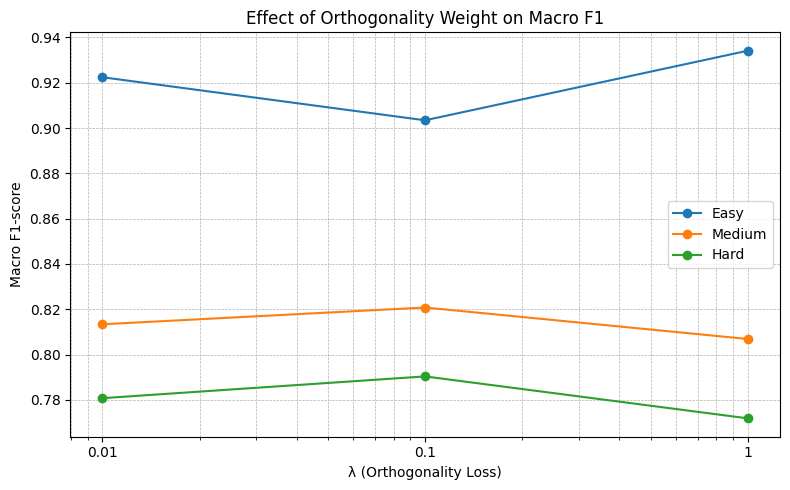

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

lambdas = [0.01, 0.1, 1]
f1_easy = [0.9224, 0.9034, 0.9341]
f1_medium = [0.8134, 0.8208, 0.8069]
f1_hard = [0.7808, 0.7904, 0.7719]

plt.figure(figsize=(8, 5))
plt.plot(lambdas, f1_easy, marker='o', label='Easy')
plt.plot(lambdas, f1_medium, marker='o', label='Medium')
plt.plot(lambdas, f1_hard, marker='o', label='Hard')

plt.xscale('log')
plt.xticks(lambdas, labels=["0.01", "0.1", "1"])
plt.xlabel('λ (Orthogonality Loss)')
plt.ylabel('Macro F1-score')
plt.title('Effect of Orthogonality Weight on Macro F1')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


filename = 'orthogonality_f1_plot.png'
plt.savefig(filename)
files.download(filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

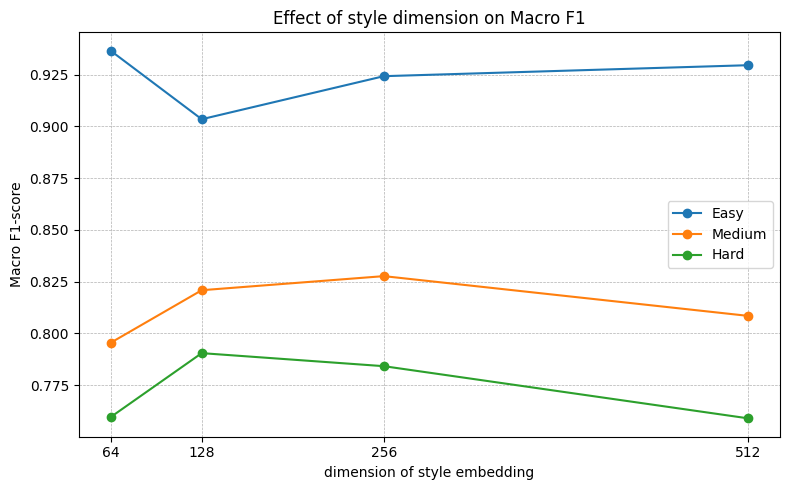

In [ ]:
import matplotlib.pyplot as plt

dims = [64, 128, 256, 512]
f1_easy = [0.9365, 0.9034, 0.9242, 0.9295]
f1_medium = [0.7954, 0.8208, 0.8276, 0.8084]
f1_hard = [0.7595, 0.7904, 0.7841, 0.7589]

plt.figure(figsize=(8, 5))
plt.plot(dims, f1_easy, marker='o', label='Easy')
plt.plot(dims, f1_medium, marker='o', label='Medium')
plt.plot(dims, f1_hard, marker='o', label='Hard')

plt.xticks(dims, labels=["64", "128", "256", "512"])
plt.xlabel('dimension of style embedding')
plt.ylabel('Macro F1-score')
plt.title('Effect of style dimension on Macro F1')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

filename = 'style_dim_f1_plot.png'
plt.savefig(filename)
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

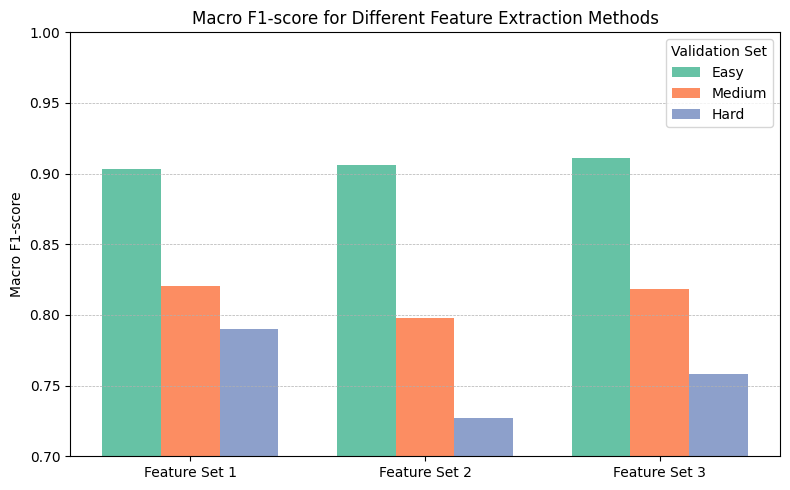

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

f1_scores = [
    [0.9034, 0.8208, 0.7904],
    [0.9058, 0.7981, 0.7274],
    [0.9113, 0.8184, 0.7580],
]


methods = ['Feature Set 1', 'Feature Set 2', 'Feature Set 3']
difficulty = ['Easy', 'Medium', 'Hard']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']


x = np.arange(len(methods))
width = 0.25


plt.figure(figsize=(8, 5))
for i in range(len(difficulty)):
    f1 = [method[i] for method in f1_scores]
    plt.bar(x + i*width - width, f1, width, label=difficulty[i], color=colors[i])

plt.ylabel('Macro F1-score')
plt.title('Macro F1-score for Different Feature Extraction Methods')
plt.xticks(x, methods)
plt.ylim(0.7, 1)
plt.legend(title='Validation Set')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

filename = 'feature_extraction_f1_plot.png'
plt.savefig(filename)
files.download(filename)




In [ ]:
!apt-get update
!apt-get install -y texlive-latex-base texlive-fonts-recommended texlive-latex-extra

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 388 kB in 3s (153 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
R

In [ ]:
!apt-get install -y texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-extra is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib as mpl
import numpy as np

mpl.use('pgf')

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],

    "pgf.preamble": "\\usepackage{newtxtext}\\usepackage{newtxmath}",

    "axes.labelsize": 8,
    "font.size": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,

    "figure.figsize": (4.5, 4),
    "lines.linewidth": 1.0,
    "grid.linestyle": '--',
    "grid.linewidth": 0.5,
})


f1_scores = [
    [0.9034, 0.8208, 0.7904],
    [0.9058, 0.7981, 0.7274],
    [0.9113, 0.8184, 0.7580],
]
methods = ['Feature set 1', 'Feature set 2', 'Feature set 3']
difficulty = ['Easy', 'Medium', 'Hard']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
hatches = ['///', '+++', '|||']


y = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots()
for i, level in enumerate(difficulty):
    values = [scores[i] for scores in f1_scores]
    bars = ax.bar(y + i*width - width, values, width, label=rf'\textbf{{{level}}}',
                  color=colors[i], hatch=hatches[i], edgecolor='black')


ax.set_ylabel(r'Macro F$_1$-score', fontsize=10)
ax.set_title(r'Macro F$_1$-score for Different Feature Extraction Methods', fontsize=12)
ax.set_xticks(y)
ax.set_xticklabels(methods)
ax.set_ylim(0.7, 1)
ax.legend(title=r'Validation set', loc='best')
ax.grid(axis='y')
plt.tight_layout()

plt.savefig('feature_extraction_f1_plot.pgf')
plt.savefig('feature_extraction_f1_plot.pdf')
files.download('feature_extraction_f1_plot.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gmpl_backend = 'pgf'
mpl.use(gmpl_backend)


mpl.rcParams.update({

    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],

    "pgf.preamble": "\\usepackage{newtxtext}\\usepackage{newtxmath}",

    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,

    "figure.figsize": (3.39, 2.53),
    "lines.linewidth": 1.0,
    "grid.linestyle": '--',
    "grid.linewidth": 0.5,
})


lambdas = [0.01, 0.1, 1]
f1_easy   = [0.9224, 0.9034, 0.9341]
f1_medium = [0.8134, 0.8208, 0.8069]
f1_hard   = [0.7808, 0.7904, 0.7719]


ticks = [0.01, 0.1, 1]
plt.plot(lambdas, f1_easy,   'o-', label="Easy")
plt.plot(lambdas, f1_medium, 's--', label="Medium")
plt.plot(lambdas, f1_hard,   'd-.', label="Hard")


plt.xscale('log')
plt.xticks(ticks, labels=["0.01", "0.1", "1"])


plt.xlabel(r'$\lambda$ (Orthogonality Loss)')
plt.ylabel(r'Macro F$_1$-score')
plt.title(r'Effect of Orthogonality Weight on Macro F$_1$')


plt.legend(loc='best')
plt.grid(True, which='both')
plt.tight_layout()


plt.savefig('orthogonality_f1_plot.pgf')
plt.savefig('orthogonality_f1_plot.pdf')
files.download('orthogonality_f1_plot.pdf')

RuntimeError: The command
    pdflatex -interaction=nonstopmode -halt-on-error figure.tex
failed and generated the following output:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./figure.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/share/texlive/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/pdftexcmds/pdftexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/infwarerr/infwarerr.sty))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kvsetkeys/kvsetkeys.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kvdefinekeys/kvdefinekeys.sty)
(/usr/share/texlive/texmf-dist/tex/generic/pdfescape/pdfescape.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hycolor/hycolor.sty)
(/usr/share/texlive/texmf-dist/tex/latex/letltxmacro/letltxmacro.sty)
(/usr/share/texlive/texmf-dist/tex/latex/auxhook/auxhook.sty)
(/usr/share/texlive/texmf-dist/tex/latex/kvoptions/kvoptions.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/pd1enc.def)
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref-langpatches.def)
(/usr/share/texlive/texmf-dist/tex/generic/intcalc/intcalc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/etexcmds/etexcmds.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/puenc.def)
(/usr/share/texlive/texmf-dist/tex/latex/url/url.sty)
(/usr/share/texlive/texmf-dist/tex/generic/bitset/bitset.sty
(/usr/share/texlive/texmf-dist/tex/generic/bigintcalc/bigintcalc.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/atbegshi-ltx.sty))
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hpdftex.def
(/usr/share/texlive/texmf-dist/tex/latex/base/atveryend-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/rerunfilecheck/rerunfilecheck.sty
(/usr/share/texlive/texmf-dist/tex/generic/uniquecounter/uniquecounter.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common-lists.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-latex.def
) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfrcs.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/pgf.revision.tex)))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgfcore.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/systemlayer/pgfsys.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfkeys.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfkeysfiltered.code.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgf.cfg)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-pdftex.def
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-common-pdf.de
f)))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsyssoftpath.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsysprotocol.code.
tex)) (/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcore.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmath.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathcalc.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathutil.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathparser.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.basic.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.trigonomet
ric.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.random.cod
e.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.comparison
.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.base.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.round.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.misc.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.integerari
thmetics.code.tex)))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfloat.code.tex))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfint.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepoints.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathconstruct.
code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathusage.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorescopes.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoregraphicstate.c
ode.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransformation
s.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorequick.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreobjects.code.t
ex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathprocessing
.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorearrows.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreshade.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreimage.code.tex

(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreexternal.code.
tex))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorelayers.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransparency.c
ode.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepatterns.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorerdf.code.tex))
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmoduleshapes.code.tex
) (/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmoduleplot.code.tex
)
(/usr/share/texlive/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version-0-65
.sty)
(/usr/share/texlive/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version-1-18
.sty)) (/usr/share/texlive/texmf-dist/tex/latex/koma-script/scrextend.sty
(/usr/share/texlive/texmf-dist/tex/latex/koma-script/scrkbase.sty
(/usr/share/texlive/texmf-dist/tex/latex/koma-script/scrbase.sty
(/usr/share/texlive/texmf-dist/tex/latex/koma-script/scrlfile.sty
(/usr/share/texlive/texmf-dist/tex/latex/koma-script/scrlfile-hook.sty
(/usr/share/texlive/texmf-dist/tex/latex/koma-script/scrlogo.sty)))))

LaTeX Warning: Command \@footnotemark  has changed.
               Check if current package is valid.

) (/usr/share/texlive/texmf-dist/tex/latex/newtx/newtxtext.sty
`newtxtext' v1.705, 2022/01/11 Text macros taking advantage of TeXGyre Termes a
nd its extensions (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifxetex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifluatex.sty)
(/usr/share/texlive/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkvutils.tex)))
(/usr/share/texlive/texmf-dist/tex/latex/etoolbox/etoolbox.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/generic/xstring/xstring.sty
(/usr/share/texlive/texmf-dist/tex/generic/xstring/xstring.tex))
(/usr/share/texlive/texmf-dist/tex/latex/base/ifthen.sty)
(/usr/share/texlive/texmf-dist/tex/latex/carlisle/scalefnt.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kastrup/binhex.tex)
(/usr/share/texlive/texmf-dist/tex/latex/fontaxes/fontaxes.sty))
(/usr/share/texlive/texmf-dist/tex/latex/newtx/newtxmath.sty
`newtxmath' v1.7, 2021/12/18 Math macros based originally on txfonts (msharpe)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/oberdiek/centernot.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kastrup/binhex.tex)
amsthm NOT loaded
) (/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/t1ntxtlf.fd)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-pdftex.def)
No file figure.aux.
(/usr/share/texlive/texmf-dist/tex/latex/newtx/omlntxmi.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/untxexa.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/lmsntxsy.fd)
(/usr/share/texlive/texmf-dist/tex/latex/newtx/lmxntxexx.fd)
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/nameref.sty
(/usr/share/texlive/texmf-dist/tex/latex/refcount/refcount.sty)
(/usr/share/texlive/texmf-dist/tex/generic/gettitlestring/gettitlestring.sty))
*geometry* driver: auto-detecting
*geometry* detected driver: pdftex
(/usr/share/texlive/texmf-dist/tex/context/base/mkii/supp-pdf.mkii
[Loading MPS to PDF converter (version 2006.09.02).]
) (/usr/share/texlive/texmf-dist/tex/latex/epstopdf-pkg/epstopdf-base.sty
(/usr/share/texlive/texmf-dist/tex/latex/latexconfig/epstopdf-sys.cfg))
(./figure.pgf
! Dimension too large.
<to be read again> 
                   \relax 
l.127 ...ansformshift{-1425.831746in}{-6.995569in}
                                                  %
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on figure.log.

and the following error:


# McNemar’s test

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
def evaluate_model_and_collect_preds(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask, features1, features2)

            # Check if model returns logits only or (logits, loss1, loss2)
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")

    return all_preds, all_labels


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class SimpleCLSClassifier(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base", hidden_dim=768):
        super(SimpleCLSClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, *args, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_embedding).squeeze(-1)
        return logits


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/basic_model.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
simple_model = SimpleCLSClassifier().to(device)
optimizer = AdamW(simple_model.parameters(), lr=1e-5)

# Load saved weights
simple_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

simple_model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

 Model loaded successfully!


In [ ]:
import torch.nn as nn
from transformers import AutoModel
import torch.nn.functional as F

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model0.1.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
factorized_model = FactorizedAttentionModel().to(device)
optimizer = AdamW(factorized_model.parameters(), lr=1e-5)

# Load saved weights
factorized_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

factorized_model.eval()

print(" Model loaded successfully!")

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
# Collect predictions
simple_model_preds, y_true = evaluate_model_and_collect_preds(simple_model, valid_df, dataset_name="Simple Model")
factorized_preds, _ = evaluate_model_and_collect_preds(factorized_model, valid_df, dataset_name="Factorized Model")

# Run McNemar’s test
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

y_true = np.array(y_true)
simple_preds = np.array(simple_model_preds)
factorized_preds = np.array(factorized_preds)

b = np.sum((simple_preds != y_true) & (factorized_preds == y_true))
c = np.sum((simple_preds == y_true) & (factorized_preds != y_true))
table = [[0, b], [c, 0]]

result = mcnemar(table, exact=True)
print("McNemar’s test p-value:", result.pvalue)


Simple Model Set - Accuracy: 0.9029, Macro F1-Score: 0.8374
Factorized Model Set - Accuracy: 0.8912, Macro F1-Score: 0.8370
McNemar’s test p-value: 5.189172989381961e-15


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_mcnemar(simple_model, factorized_model, df, dataset_name):
    print(f"\n {dataset_name} Set")

    # Get predictions and true labels
    simple_preds, y_true = evaluate_model_and_collect_preds(simple_model, df, dataset_name="Simple")
    factorized_preds, _ = evaluate_model_and_collect_preds(factorized_model, df, dataset_name="Factorized")

    y_true = np.array(y_true)
    simple_preds = np.array(simple_preds)
    factorized_preds = np.array(factorized_preds)

    # McNemar's contingency table
    a1 = np.sum(y_true == factorized_preds)
    a2 = np.sum(y_true != factorized_preds)
    b = np.sum((simple_preds != y_true) & (factorized_preds == y_true))
    c = np.sum((simple_preds == y_true) & (factorized_preds != y_true))
    table = [[0, b], [c, 0]]

    # Run McNemar's Test
    result = mcnemar(table, exact=True)

    # Classification metrics
    for name, preds in [("Simple", simple_preds), ("Factorized", factorized_preds)]:
        precision = precision_score(y_true, preds)
        recall = recall_score(y_true, preds)
        print(f" {name} Model — Precision: {precision:.4f}, Recall: {recall:.4f}")

    print(f" McNemar’s Test: a1 = {a1}, a2 = {a2}, b = {b}, c = {c}, p-value = {result.pvalue:.4e}")
    return result.pvalue


In [ ]:
# Subsets
easy_df = valid_df[valid_df["difficulty"] == "easy"]
medium_df = valid_df[valid_df["difficulty"] == "medium"]
hard_df = valid_df[valid_df["difficulty"] == "hard"]

# Run McNemar’s test per difficulty level
p_easy = run_mcnemar(simple_model, factorized_model, easy_df, "Easy")
p_medium = run_mcnemar(simple_model, factorized_model, medium_df, "Medium")
p_hard = run_mcnemar(simple_model, factorized_model, hard_df, "Hard")


 Easy Set
Simple Set - Accuracy: 0.9460, Macro F1-Score: 0.9167
Factorized Set - Accuracy: 0.9336, Macro F1-Score: 0.9034
 Simple Model — Precision: 0.9200, Recall: 0.8201
 Factorized Model — Precision: 0.8291, Recall: 0.8705
 McNemar’s Test: a1 = 9567, a2 = 680, b = 183, c = 310, p-value = 1.1606e-08

 Medium Set
Simple Set - Accuracy: 0.8940, Macro F1-Score: 0.8216
Factorized Set - Accuracy: 0.8837, Macro F1-Score: 0.8208
 Simple Model — Precision: 0.8722, Recall: 0.5956
 Factorized Model — Precision: 0.7582, Recall: 0.6760
 McNemar’s Test: a1 = 11275, a2 = 1484, b = 339, c = 471, p-value = 3.9781e-06

 Hard Set
Simple Set - Accuracy: 0.8721, Macro F1-Score: 0.7669
Factorized Set - Accuracy: 0.8592, Macro F1-Score: 0.7904
 Simple Model — Precision: 0.6711, Recall: 0.5598
 Factorized Model — Precision: 0.5771, Recall: 0.7996
 McNemar’s Test: a1 = 9149, a2 = 1499, b = 560, c = 697, p-value = 1.2332e-04


# Tuning style_dim = 64

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=64, content_dim=64, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


Epoch 1/3:
Total Loss: 0.5216
Classification Loss: 0.4076
Orthogonality Loss: 0.0015
Feature Alignment Loss: 0.1139


Epoch 2/3:
Total Loss: 0.3083
Classification Loss: 0.2715
Orthogonality Loss: 0.0009
Feature Alignment Loss: 0.0367


Epoch 3/3:
Total Loss: 0.2648
Classification Loss: 0.2369
Orthogonality Loss: 0.0011
Feature Alignment Loss: 0.0278



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model64.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model64.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model64.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9564, Macro F1-Score: 0.9365
Medium Validation Set - Accuracy: 0.8806, Macro F1-Score: 0.7954
Hard Validation Set - Accuracy: 0.8629, Macro F1-Score: 0.7595


# Tuning style_dim = 256

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=256, content_dim=256, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


Epoch 1/3:
Total Loss: 0.4342
Classification Loss: 0.3178
Orthogonality Loss: 0.0004
Feature Alignment Loss: 0.1163


Epoch 2/3:
Total Loss: 0.2742
Classification Loss: 0.2284
Orthogonality Loss: 0.0006
Feature Alignment Loss: 0.0457


Epoch 3/3:
Total Loss: 0.2158
Classification Loss: 0.1853
Orthogonality Loss: 0.0002
Feature Alignment Loss: 0.0305



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model256.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model256.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model256.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9487, Macro F1-Score: 0.9242
Medium Validation Set - Accuracy: 0.8936, Macro F1-Score: 0.8276
Hard Validation Set - Accuracy: 0.8675, Macro F1-Score: 0.7841


# Tuning style_dim = 512

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=512, content_dim=512, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)


Epoch 1/3:
Total Loss: 0.4856
Classification Loss: 0.3389
Orthogonality Loss: 0.0002
Feature Alignment Loss: 0.1466


Epoch 2/3:
Total Loss: 0.3099
Classification Loss: 0.2388
Orthogonality Loss: 0.0005
Feature Alignment Loss: 0.0711


Epoch 3/3:
Total Loss: 0.2399
Classification Loss: 0.1990
Orthogonality Loss: 0.0002
Feature Alignment Loss: 0.0409



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced_factorized_attention_model512.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced_factorized_attention_model512.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model512.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9543, Macro F1-Score: 0.9295
Medium Validation Set - Accuracy: 0.8896, Macro F1-Score: 0.8084
Hard Validation Set - Accuracy: 0.8735, Macro F1-Score: 0.7589


# Enhanced 2.0

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base", hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # DeBERTa backbone
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized projections
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Handcrafted feature projection
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Learnable gating mechanism for style-content separation
        self.gate_layer = nn.Linear(feature_dim * 2, 1)

        # Classification head
        self.classifier = nn.Linear(style_dim * 2, 1)

        # Regularization layers
        self.dropout = nn.Dropout(0.2)
        self.norm = nn.LayerNorm(style_dim)

        # Loss weights
        self.ortho_lambda = 0.1
        self.contrastive_lambda = 0.01
        self.style_feature_lambda = 1.0

    def forward(self, input_ids, attention_mask, features1, features2, labels=None):
        # Encode input
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]

        # Project to factorized embeddings
        content_embedding = self.content_proj(embeddings)
        style_embedding = self.style_proj(embeddings)

        # Handcrafted feature processing
        combined_features = torch.cat([features1, features2], dim=-1)
        feature_embedding = self.feature_proj(combined_features)

        # Learnable gate: controls style vs. content emphasis
        gate = torch.sigmoid(self.gate_layer(combined_features))
        content_embedding = content_embedding * (1 - gate)
        style_embedding = style_embedding * gate

        # Apply dropout and normalization
        style_embedding = self.norm(self.dropout(style_embedding))
        content_embedding = self.norm(self.dropout(content_embedding))

        # Orthogonality loss between content and style
        content_norm = F.normalize(content_embedding, dim=-1)
        style_norm = F.normalize(style_embedding, dim=-1)
        ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

        # Feature-style alignment loss
        style_feature_loss = 1 - F.cosine_similarity(
            F.normalize(style_embedding, dim=-1),
            F.normalize(feature_embedding, dim=-1)
        ).mean()

        # Final classification
        combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
        logits = self.classifier(combined_rep).squeeze(-1)

        # Contrastive loss (optional, only if labels are provided)
        contrastive_loss = torch.tensor(0.0, device=logits.device)
        if labels is not None:
            # Assume binary labels: 1 if same author, 0 if not
            contrastive_loss = self.compute_contrastive_loss(style_embedding, labels)

        return logits, ortho_loss, style_feature_loss, contrastive_loss

    def compute_contrastive_loss(self, embeddings, labels, margin=1.0):
        # Pairwise contrastive loss over batch
        batch_size = embeddings.size(0)
        loss = 0.0
        pairs = 0

        for i in range(batch_size):
            for j in range(i + 1, batch_size):
                dist = F.pairwise_distance(embeddings[i:i+1], embeddings[j:j+1])
                target = (labels[i] == labels[j]).float()
                loss += (1 - target) * dist.pow(2) + target * F.relu(margin - dist).pow(2)
                pairs += 1

        return loss / pairs if pairs > 0 else torch.tensor(0.0, device=embeddings.device)


In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

def train_model(model, train_loader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0
        total_contrastive_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss, contrastive_loss = model(
                input_ids, attention_mask, features1, features2, labels
            )

            # Compute losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (
                cls_loss
                + model.ortho_lambda * ortho_loss
                + model.style_feature_lambda * style_feature_loss
                + model.contrastive_lambda * contrastive_loss
            )

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Track loss values
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()
            total_contrastive_loss += contrastive_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss:              {total_loss / num_batches:.4f}")
        print(f"Classification Loss:     {total_cls_loss / num_batches:.4f}")
        print(f"Orthogonality Loss:      {total_ortho_loss / num_batches:.4f}")
        print(f"Feature Alignment Loss:  {total_feat_loss / num_batches:.4f}")
        print(f"Contrastive Loss:        {total_contrastive_loss / num_batches:.4f}\n")


train_model(model, train_loader, optimizer, epochs=3)


Epoch 1/3:
Total Loss:              1.3293
Classification Loss:     0.5770
Orthogonality Loss:      2.5546
Feature Alignment Loss:  0.3019
Contrastive Loss:        19.4923


Epoch 2/3:
Total Loss:              0.9365
Classification Loss:     0.3531
Orthogonality Loss:      1.7511
Feature Alignment Loss:  0.2117
Contrastive Loss:        19.6674


Epoch 3/3:
Total Loss:              0.8554
Classification Loss:     0.3181
Orthogonality Loss:      1.4971
Feature Alignment Loss:  0.1901
Contrastive Loss:        19.7472



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/enhenced2.0_factorized_attention_model.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/enhenced2.0_factorized_attention_model.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced2.0_factorized_attention_model.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            logits, _, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9362, Macro F1-Score: 0.8980
Medium Validation Set - Accuracy: 0.8813, Macro F1-Score: 0.7861
Hard Validation Set - Accuracy: 0.8480, Macro F1-Score: 0.6625


# Save weights only

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

model_name = "microsoft/deberta-v3-base"
class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model0.1.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/small_factorized_attention_model.pt"

# Save model weights
torch.save(model.state_dict(), model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/small_factorized_attention_model.pt


In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FactorizedAttentionModel().to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/small_factorized_attention_model.pt"))
model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9336, Macro F1-Score: 0.9034
Medium Validation Set - Accuracy: 0.8837, Macro F1-Score: 0.8208
Hard Validation Set - Accuracy: 0.8592, Macro F1-Score: 0.7904


# Content only

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1   
4  While the Saudi royal family is a very authori...      0   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_dim = AutoConfig.from_pretrained(model_name).hidden_size

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.01  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([content_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            # Forward pass
            logits, ortho_loss, style_feature_loss = model(
                input_ids, attention_mask, features1, features2
            )

            # Calculate losses
            cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
            loss = (cls_loss +
                   model.ortho_lambda * ortho_loss +
                   style_feature_loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


Epoch 1/3:
Total Loss: 0.5411
Classification Loss: 0.5007
Orthogonality Loss: 0.0008
Feature Alignment Loss: 0.0404


Epoch 2/3:
Total Loss: 0.4750
Classification Loss: 0.4646
Orthogonality Loss: 0.0006
Feature Alignment Loss: 0.0105


Epoch 3/3:
Total Loss: 0.4695
Classification Loss: 0.4621
Orthogonality Loss: 0.0006
Feature Alignment Loss: 0.0074



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/content_only_factorized_attention_model.pt"

# Save model weights
torch.save(model.state_dict(), model_save_path)

print(f" Model saved to {model_save_path}")

In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FactorizedAttentionModel().to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/content_only_factorized_attention_model.pt"))
model.eval()

print(" Model loaded successfully!")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9459, Macro F1-Score: 0.9179
Medium Validation Set - Accuracy: 0.8842, Macro F1-Score: 0.8015
Hard Validation Set - Accuracy: 0.8653, Macro F1-Score: 0.7551


# Feature Re-extraction

In [ ]:
# Install necessary dependencies
!pip install nltk pandas tqdm requests

import os
import json
import pandas as pd
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Define dataset URL and paths
ZIP_URL = "https://zenodo.org/records/14891299/files/pan25-multi-author-analysis.zip?download=1"
ZIP_PATH = "pan25-multi-author-analysis.zip"
EXTRACT_FOLDER = "pan25_data"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Download the ZIP file
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(save_path, "wb") as file, tqdm(
        desc="Downloading Dataset",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
            bar.update(len(chunk))

# Unzip the dataset
def unzip_file(zip_path, extract_folder):
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Extracted to {extract_folder}")

# Download and unzip dataset
download_file(ZIP_URL, ZIP_PATH)
unzip_file(ZIP_PATH, EXTRACT_FOLDER)

# Define the root directory where the extracted folders exist
DATASET_ROOT = Path(EXTRACT_FOLDER)

# Define dataset splits
SPLITS = ["train", "validation"]
DIFFICULTY_LEVELS = ["easy", "medium", "hard"]

# Read and process the dataset
def read_problem_data(problem_file):
    text_path = problem_file
    json_path = text_path.with_name(f"truth-{text_path.stem}.json")

    # Read text
    with open(text_path, "r", encoding="utf-8") as f:
        text = f.read().strip()

    # Read labels
    with open(json_path, "r", encoding="utf-8") as f:
        truth = json.load(f)

    return text, truth["changes"]

Extracted to pan25_data


In [ ]:
# Define the file path
file_path = "pan25_data/hard/train/problem-3207.txt"

# New content to write
new_content = """Intelligence agencies aren't spying about pandemics folks.
The world has many interacting medical based organizations that monitor pandemics all the time.
Looking to the DoD or CIA or any other intelligence org to be the source of pandemic intelligence other than from a defense angle is a not their primary role.
Again, by rule, the NCMI is the lead agency on pandemic intelligence for the United States.
It's not an exception.
Additionally, the NCMI doesn't solely view medical intelligence from the lens of a "defense angle" as you believe.
But regardless, my comment originally rebutted your comment "Intelligence agencies aren't spying about pandemics folks."
Yes it does.
It's called the NCMI.
a.
There will be a unified Defense community for medical intelligence activities; those activities will be executed in a coordinated and coherent manner to effectively respond to U.S. intelligence priorities in support of national security objectives, and in accordance with all applicable laws, Presidential directives, DoD issuances, and Director of National Intelligence (DNI) guidelines.
From multiple angles; not solely based on a defense posture.
Where's your DOD policy citation that it's solely for defense posture?
"""

# Overwrite the file
with open(file_path, "w", encoding="utf-8") as f:
    f.write(new_content)

print(f"Successfully updated {file_path}")


Successfully updated pan25_data/hard/train/problem-3207.txt


In [ ]:
def process_dataset(split):
    dataset = []
    total_mismatched_pairs = 0  # Counter for total mismatched pairs

    for difficulty in DIFFICULTY_LEVELS:
        print(f"Processing {split} set - {difficulty} difficulty...")
        folder_path = DATASET_ROOT / difficulty / split

        for problem_file in tqdm(folder_path.glob("problem-*.txt")):
            with open(problem_file, "r", encoding="utf-8") as f:
                lines = f.readlines()

            # Strip whitespace and remove empty lines
            sentences = [line.strip() for line in lines if line.strip()]

            # Read corresponding labels
            _, labels = read_problem_data(problem_file)

            # Check for label mismatch
            if len(labels) != len(sentences) - 1:
                mismatch_count = abs(len(labels) - (len(sentences) - 1))
                total_mismatched_pairs += mismatch_count

                print(f"\n Label mismatch in {problem_file}")
                print(f" Total Sentences (Lines): {len(sentences)} | Expected Labels: {len(labels)}")
                print(f" Mismatched Pairs in This File: {mismatch_count}")

                # Print mismatched sentence-label pairs
                print("\n--- Mismatched Sentence Pairs ---")
                for i in range(min(len(sentences) - 1, len(labels), 5)):
                    print(f"[{i}] {sentences[i]} || {sentences[i+1]} --> Label: {labels[i]}")

                print("--- End of Mismatch ---\n")
                continue

            # Merge consecutive sentences for training
            for i in range(len(sentences) - 1):
                dataset.append({
                    "difficulty": difficulty,
                    "split": split,
                    "problem_id": problem_file.stem,
                    "sentence1": sentences[i],
                    "sentence2": sentences[i + 1],
                    "label": labels[i]
                })

    print(f"\n Total Mismatched Sentence-Label Pairs Across All Files: {total_mismatched_pairs}")
    return dataset
# Process both training and validation sets
train_data = process_dataset("train")
valid_data = process_dataset("validation")

# Convert to DataFrame and save as CSV
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

train_df.to_csv("train_dataset.csv", index=False)
valid_df.to_csv("valid_dataset.csv", index=False)

print("Training and validation datasets saved successfully!")

Processing train set - easy difficulty...


4200it [00:02, 2092.54it/s]


Processing train set - medium difficulty...


4200it [00:02, 2010.54it/s]


Processing train set - hard difficulty...


4200it [00:01, 2705.38it/s]



 Total Mismatched Sentence-Label Pairs Across All Files: 0
Processing validation set - easy difficulty...


900it [00:00, 3958.04it/s]


Processing validation set - medium difficulty...


900it [00:00, 3764.48it/s]


Processing validation set - hard difficulty...


900it [00:00, 2865.35it/s]



 Total Mismatched Sentence-Label Pairs Across All Files: 0
Training and validation datasets saved successfully!


In [ ]:
# Load processed datasets
train_df = pd.read_csv("train_dataset.csv")
valid_df = pd.read_csv("valid_dataset.csv")

# Show unique label counts
print("\n Label Distribution in Training Set:")
print(train_df['label'].value_counts())

print("\n Label Distribution in Validation Set:")
print(valid_df['label'].value_counts())


 Label Distribution in Training Set:
label
0    126738
1     31542
Name: count, dtype: int64

 Label Distribution in Validation Set:
label
0    26797
1     6857
Name: count, dtype: int64


In [ ]:
import spacy
import textstat
import numpy as np
from collections import Counter
import re

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Define Reddit-style elements
slang = {"lol", "brb", "idk", "imo", "smh", "tbh", "rofl", "lmao"}
uppercase_pattern = re.compile(r"[A-Z]{2,}")
url_pattern = re.compile(r"https?://|www\.")

# Define common pronouns used as subjects
subject_pronouns = {"i", "we", "you", "he", "she", "they", "it"}

def extract_features(text):
    doc = nlp(text)

    # Stylometric & Reddit-style
    punctuation_count = sum(1 for char in text if char in ".,!?;:-")
    uppercase_ratio = len(uppercase_pattern.findall(text)) / (len(text) + 1)
    url_count = len(url_pattern.findall(text))
    slang_count = sum(1 for token in doc if token.text.lower() in slang)

    # Lexical
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    type_token_ratio = len(set(tokens)) / (len(tokens) + 1) if tokens else 0

    # Function word usage
    function_words = {"the", "is", "and", "but", "or", "because", "as", "that"}
    function_word_count = sum(1 for token in doc if token.text.lower() in function_words)

    # Sentence complexity
    sentence_lengths = [len(sent) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0
    readability_score = textstat.flesch_reading_ease(text)

    # Subject structure features
    has_subject = 0
    is_pronoun_subject = 0
    is_noun_subject = 0
    for token in doc:
        if token.dep_ in {"nsubj", "nsubjpass"}:
            has_subject = 1
            if token.text.lower() in subject_pronouns:
                is_pronoun_subject = 1
            else:
                is_noun_subject = 1
            break

    # Final feature vector
    return [
        function_word_count,
        punctuation_count,
        type_token_ratio,
        avg_sentence_length,
        readability_score,
        uppercase_ratio,
        slang_count,
        url_count,
        has_subject,
        is_pronoun_subject,
        is_noun_subject
    ]


In [ ]:
# Apply feature extraction to dataset
train_df["features1"] = train_df["sentence1"].apply(extract_features)
train_df["features2"] = train_df["sentence2"].apply(extract_features)
valid_df["features1"] = valid_df["sentence1"].apply(extract_features)
valid_df["features2"] = valid_df["sentence2"].apply(extract_features)

print(" Feature extraction completed!")


 Feature extraction completed!


In [ ]:
import pickle

# Save extracted features along with dataset
train_df.to_csv("enhanced_train_features.csv", index=False)
valid_df.to_csv("enhanced_valid_features.csv", index=False)

# Save as Pickle for faster loading
with open("enhanced_train_features.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("valid_features.pkl", "wb") as f:
    pickle.dump(valid_df, f)

from google.colab import drive
drive.mount('/content/drive')
train_df.to_pickle("/content/drive/My Drive/enhanced_train_features.pkl")
valid_df.to_pickle("/content/drive/My Drive/enhanced_valid_features.pkl")

Mounted at /content/drive


# Save weights only using new features

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/enhanced_train_features.pkl"
valid_features_path = "/content/drive/My Drive/enhanced_valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-2421   
1       easy  train  problem-2421   
2       easy  train  problem-2421   
3       easy  train  problem-2421   
4       easy  train  problem-2421   

                                           sentence1  \
0  “The outrage we’re seeing across the country r...   
1                               Thanks for the link.   
2  The article talks about municipalities and pol...   
3  Only mention of federal government is that the...   
4  Which is why we ended up with a shit show of d...   

                                           sentence2  label  \
0                               Thanks for the link.      1   
1  The article talks about municipalities and pol...      0   
2  Only mention of federal government is that the...      0   
3  Which is why we ended up with a shit show of d...      0

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

model_name = "microsoft/deberta-v3-base"
class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=11):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            optimizer.zero_grad()
            with autocast():  # mixed precision
                logits, ortho_loss, style_feature_loss = model(
                    input_ids, attention_mask, features1, features2
                )
                cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
                loss = cls_loss + model.ortho_lambda * ortho_loss + style_feature_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

<ipython-input-4-e814a2cbe25b>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-4-e814a2cbe25b>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision



Epoch 1/3:
Total Loss: 0.6227
Classification Loss: 0.4262
Orthogonality Loss: 0.0172
Feature Alignment Loss: 0.1793


Epoch 2/3:
Total Loss: 0.4088
Classification Loss: 0.2758
Orthogonality Loss: 0.0041
Feature Alignment Loss: 0.1290


Epoch 3/3:
Total Loss: 0.3280
Classification Loss: 0.2331
Orthogonality Loss: 0.0032
Feature Alignment Loss: 0.0917



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/small_factorized_attention_model1.pt"

# Save model weights
torch.save(model.state_dict(), model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/small_factorized_attention_model1.pt


In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FactorizedAttentionModel().to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/small_factorized_attention_model1.pt"))
model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9402, Macro F1-Score: 0.9058
Medium Validation Set - Accuracy: 0.8859, Macro F1-Score: 0.7981
Hard Validation Set - Accuracy: 0.8650, Macro F1-Score: 0.7274


# Ablation Study CLS + Orthogonality Loss

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class CLSOrthogonalModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, ortho_lambda=0.1):
        super(CLSOrthogonalModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        # Style & content heads
        self.style_proj = nn.Linear(hidden_dim, style_dim)
        self.content_proj = nn.Linear(hidden_dim, content_dim)

        # Classifier: style + content
        self.classifier = nn.Linear(style_dim + content_dim, 1)
        self.ortho_lambda = ortho_lambda

    def forward(self, input_ids, attention_mask, *args, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Project heads
        style_embedding = self.style_proj(cls_embedding)
        content_embedding = self.content_proj(cls_embedding)

        # Orthogonality loss
        style_norm = F.normalize(style_embedding, dim=-1)
        content_norm = F.normalize(content_embedding, dim=-1)
        ortho_loss = torch.norm(torch.matmul(style_norm, content_norm.T)) ** 2

        # Combine & classify
        combined = torch.cat([style_embedding, content_embedding], dim=-1)
        logits = self.classifier(combined).squeeze(-1)

        return logits, ortho_loss


In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLSOrthogonalModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            optimizer.zero_grad()
            with autocast():  # mixed precision
                logits, ortho_loss = model(
                    input_ids, attention_mask, features1, features2
                )
                cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
                loss = cls_loss + model.ortho_lambda * ortho_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")

train_model(model, train_loader, epochs=3)

<ipython-input-4-ccc59152b14e>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-4-ccc59152b14e>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision



Epoch 1/3:
Total Loss: 0.4030
Classification Loss: 0.3529
Orthogonality Loss: 0.5010

Epoch 2/3:
Total Loss: 0.2500
Classification Loss: 0.2421
Orthogonality Loss: 0.0792

Epoch 3/3:
Total Loss: 0.2060
Classification Loss: 0.2027
Orthogonality Loss: 0.0332


In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/CLS_Orthogonality_model.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/CLS_Orthogonality_model.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/CLS_Orthogonality_model.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = CLSOrthogonalModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            logits, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9350, Macro F1-Score: 0.9025
Medium Validation Set - Accuracy: 0.8901, Macro F1-Score: 0.8258
Hard Validation Set - Accuracy: 0.8645, Macro F1-Score: 0.7852


# Ablation Study CLS + Style Features

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/train_features.pkl"
valid_features_path = "/content/drive/My Drive/valid_features.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  difficulty  split    problem_id  \
0       easy  train  problem-1420   
1       easy  train  problem-1420   
2       easy  train  problem-1420   
3       easy  train  problem-1420   
4       easy  train  problem-1420   

                                           sentence1  \
0  This speaks to a fundamental misunderstanding ...   
1  The ones with true power, like Jiang, don't ne...   
2  Jiang stacked the party with loyalists so he c...   
3  Xi needs a third term because he lacks a cliqu...   
4                                   Not necessarily.   

                                           sentence2  label  \
0  The ones with true power, like Jiang, don't ne...      0   
1  Jiang stacked the party with loyalists so he c...      0   
2  Xi needs a third term because he lacks a cliqu...      0   
3                                   Not necessarily.      1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class CLSStyleFeatureModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, feature_dim=7):
        super(CLSStyleFeatureModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        # Project handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classifier: [CLS] + style features
        self.classifier = nn.Linear(hidden_dim + style_dim, 1)

    def forward(self, input_ids, attention_mask, features1, features2):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Handcrafted feature projection
        combined_features = torch.cat([features1, features2], dim=-1)
        feature_embedding = self.feature_proj(combined_features)

        # Concatenate and classify
        combined_rep = torch.cat([cls_embedding, feature_embedding], dim=-1)
        logits = self.classifier(combined_rep).squeeze(-1)

        return logits


In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLSStyleFeatureModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            optimizer.zero_grad()
            with autocast():  # mixed precision
                logits = model(
                    input_ids, attention_mask, features1, features2
                )
                cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
                loss = cls_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()


        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")

train_model(model, train_loader, epochs=3)

<ipython-input-5-6027a7fd7f34>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-5-6027a7fd7f34>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision



Epoch 1/3:
Classification Loss: 0.3017

Epoch 2/3:
Classification Loss: 0.2216

Epoch 3/3:
Classification Loss: 0.1788


In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/CLS_Features_model.pt"

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/CLS_Features_model.pt


In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/CLS_Features_model.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = CLSStyleFeatureModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9324, Macro F1-Score: 0.8980
Medium Validation Set - Accuracy: 0.8913, Macro F1-Score: 0.8248
Hard Validation Set - Accuracy: 0.8681, Macro F1-Score: 0.7912


# Feature Re-extraction 2.0

In [ ]:
# Install necessary dependencies
!pip install nltk pandas tqdm requests

import os
import json
import pandas as pd
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Define dataset URL and paths
ZIP_URL = "https://zenodo.org/records/14891299/files/pan25-multi-author-analysis.zip?download=1"
ZIP_PATH = "pan25-multi-author-analysis.zip"
EXTRACT_FOLDER = "pan25_data"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Download the ZIP file
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(save_path, "wb") as file, tqdm(
        desc="Downloading Dataset",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
            bar.update(len(chunk))

# Unzip the dataset
def unzip_file(zip_path, extract_folder):
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Extracted to {extract_folder}")

# Download and unzip dataset
download_file(ZIP_URL, ZIP_PATH)
unzip_file(ZIP_PATH, EXTRACT_FOLDER)

# Define the root directory where the extracted folders exist
DATASET_ROOT = Path(EXTRACT_FOLDER)

# Define dataset splits
SPLITS = ["train", "validation"]
DIFFICULTY_LEVELS = ["easy", "medium", "hard"]

# Read and process the dataset
def read_problem_data(problem_file):
    text_path = problem_file
    json_path = text_path.with_name(f"truth-{text_path.stem}.json")

    # Read text
    with open(text_path, "r", encoding="utf-8") as f:
        text = f.read().strip()

    # Read labels
    with open(json_path, "r", encoding="utf-8") as f:
        truth = json.load(f)

    return text, truth["changes"]

Extracted to pan25_data


In [ ]:
# Define the file path
file_path = "pan25_data/hard/train/problem-3207.txt"

# New content to write
new_content = """Intelligence agencies aren't spying about pandemics folks.
The world has many interacting medical based organizations that monitor pandemics all the time.
Looking to the DoD or CIA or any other intelligence org to be the source of pandemic intelligence other than from a defense angle is a not their primary role.
Again, by rule, the NCMI is the lead agency on pandemic intelligence for the United States.
It's not an exception.
Additionally, the NCMI doesn't solely view medical intelligence from the lens of a "defense angle" as you believe.
But regardless, my comment originally rebutted your comment "Intelligence agencies aren't spying about pandemics folks."
Yes it does.
It's called the NCMI.
a.
There will be a unified Defense community for medical intelligence activities; those activities will be executed in a coordinated and coherent manner to effectively respond to U.S. intelligence priorities in support of national security objectives, and in accordance with all applicable laws, Presidential directives, DoD issuances, and Director of National Intelligence (DNI) guidelines.
From multiple angles; not solely based on a defense posture.
Where's your DOD policy citation that it's solely for defense posture?
"""

# Overwrite the file
with open(file_path, "w", encoding="utf-8") as f:
    f.write(new_content)

print(f"Successfully updated {file_path}")


Successfully updated pan25_data/hard/train/problem-3207.txt


In [ ]:
def process_dataset(split):
    dataset = []
    total_mismatched_pairs = 0  # Counter for total mismatched pairs

    for difficulty in DIFFICULTY_LEVELS:
        print(f"Processing {split} set - {difficulty} difficulty...")
        folder_path = DATASET_ROOT / difficulty / split

        for problem_file in tqdm(folder_path.glob("problem-*.txt")):
            with open(problem_file, "r", encoding="utf-8") as f:
                lines = f.readlines()

            # Strip whitespace and remove empty lines
            sentences = [line.strip() for line in lines if line.strip()]

            # Read corresponding labels
            _, labels = read_problem_data(problem_file)

            # Check for label mismatch
            if len(labels) != len(sentences) - 1:
                mismatch_count = abs(len(labels) - (len(sentences) - 1))
                total_mismatched_pairs += mismatch_count

                print(f"\n Label mismatch in {problem_file}")
                print(f" Total Sentences (Lines): {len(sentences)} | Expected Labels: {len(labels)}")
                print(f" Mismatched Pairs in This File: {mismatch_count}")

                # Print mismatched sentence-label pairs
                print("\n--- Mismatched Sentence Pairs ---")
                for i in range(min(len(sentences) - 1, len(labels), 5)):
                    print(f"[{i}] {sentences[i]} || {sentences[i+1]} --> Label: {labels[i]}")

                print("--- End of Mismatch ---\n")
                continue

            # Merge consecutive sentences for training
            for i in range(len(sentences) - 1):
                dataset.append({
                    "difficulty": difficulty,
                    "split": split,
                    "problem_id": problem_file.stem,
                    "sentence1": sentences[i],
                    "sentence2": sentences[i + 1],
                    "label": labels[i]
                })

    print(f"\n Total Mismatched Sentence-Label Pairs Across All Files: {total_mismatched_pairs}")
    return dataset
# Process both training and validation sets
train_data = process_dataset("train")
valid_data = process_dataset("validation")

# Convert to DataFrame and save as CSV
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

train_df.to_csv("train_dataset.csv", index=False)
valid_df.to_csv("valid_dataset.csv", index=False)

print("Training and validation datasets saved successfully!")

Processing train set - easy difficulty...


4200it [00:00, 5360.30it/s]


Processing train set - medium difficulty...


4200it [00:01, 3148.58it/s]


Processing train set - hard difficulty...


4200it [00:02, 1960.83it/s]



 Label mismatch in pan25_data/hard/train/problem-3207.txt
 Total Sentences (Lines): 14 | Expected Labels: 12
 Mismatched Pairs in This File: 1

--- Mismatched Sentence Pairs ---
[0] Intelligence agencies aren't spying about pandemics folks. || The world has many interacting medical based organizations that monitor pandemics all the time. --> Label: 0
[1] The world has many interacting medical based organizations that monitor pandemics all the time. || Looking to the DoD or CIA or any other intelligence org to be the source of pandemic intelligence other than from a defense angle is a not their primary role. --> Label: 0
[2] Looking to the DoD or CIA or any other intelligence org to be the source of pandemic intelligence other than from a defense angle is a not their primary role. || Again, by rule, the NCMI is the lead agency on pandemic intelligence for the United States. --> Label: 1
[3] Again, by rule, the NCMI is the lead agency on pandemic intelligence for the United States. || I

900it [00:00, 3147.51it/s]


Processing validation set - medium difficulty...


900it [00:00, 2047.92it/s]


Processing validation set - hard difficulty...


900it [00:00, 2854.61it/s]



 Total Mismatched Sentence-Label Pairs Across All Files: 0
Training and validation datasets saved successfully!


In [ ]:
# Load processed datasets
train_df = pd.read_csv("train_dataset.csv")
valid_df = pd.read_csv("valid_dataset.csv")

# Show unique label counts
print("\n Label Distribution in Training Set:")
print(train_df['label'].value_counts())

print("\n Label Distribution in Validation Set:")
print(valid_df['label'].value_counts())


 Label Distribution in Training Set:
label
0    126727
1     31541
Name: count, dtype: int64

 Label Distribution in Validation Set:
label
0    26797
1     6857
Name: count, dtype: int64


In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:00


In [ ]:
import spacy
import textstat
import numpy as np
from collections import Counter
import re

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Define Reddit-style elements
uppercase_pattern = re.compile(r"[A-Z]{2,}")

# Define common pronouns used as subjects
subject_pronouns = {"i", "we", "you", "he", "she", "they", "it"}

POS_NGRAMS = [
    "NOUN-VERB", "PRON-VERB", "ADJ-NOUN", "VERB-ADV",
    "PRON-AUX-VERB", "ADP-DET-NOUN", "DET-ADJ-NOUN"
]

def get_pos_ngrams(pos_tags, n):
    return ['-'.join(pos_tags[i:i+n]) for i in range(len(pos_tags)-n+1)]

def extract_features(text):
    doc = nlp(text)

    # Stylometric & Reddit-style
    punctuation_count = sum(1 for char in text if char in ".,!?;:-")
    uppercase_ratio = len(uppercase_pattern.findall(text)) / (len(text) + 1)

    # Lexical
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    type_token_ratio = len(set(tokens)) / (len(tokens) + 1) if tokens else 0

    # Function word usage
    function_words = {"the", "is", "and", "but", "or", "because", "as", "that"}
    function_word_count = sum(1 for token in doc if token.text.lower() in function_words)

    # Sentence complexity
    sentence_lengths = [len(sent) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0
    readability_score = textstat.flesch_reading_ease(text)

    # Subject structure features
    has_subject = 0
    is_pronoun_subject = 0
    is_noun_subject = 0
    for token in doc:
        if token.dep_ in {"nsubj", "nsubjpass"}:
            has_subject = 1
            if token.text.lower() in subject_pronouns:
                is_pronoun_subject = 1
            else:
                is_noun_subject = 1
            break

    # POS n-gram features
    pos_tags = [token.pos_ for token in doc]
    pos_bigrams = get_pos_ngrams(pos_tags, 2)
    pos_trigrams = get_pos_ngrams(pos_tags, 3)
    all_ngrams = pos_bigrams + pos_trigrams

    pos_ngram_counts = Counter(all_ngrams)
    pos_ngram_features = [pos_ngram_counts.get(ngram, 0) for ngram in POS_NGRAMS]

    # Final feature vector
    return [
        function_word_count,
        punctuation_count,
        type_token_ratio,
        avg_sentence_length,
        readability_score,
        uppercase_ratio,
        has_subject,
        is_pronoun_subject,
        is_noun_subject,
        *pos_ngram_features
    ]

In [ ]:
# Apply feature extraction to dataset
train_df["features1"] = train_df["sentence1"].apply(extract_features)
train_df["features2"] = train_df["sentence2"].apply(extract_features)
valid_df["features1"] = valid_df["sentence1"].apply(extract_features)
valid_df["features2"] = valid_df["sentence2"].apply(extract_features)

print(" Feature extraction completed!")


 Feature extraction completed!


In [ ]:
import pickle

# Save extracted features along with dataset
train_df.to_csv("enhanced_train_features2.0.csv", index=False)
valid_df.to_csv("enhanced_valid_features2.0.csv", index=False)

# Save as Pickle for faster loading
with open("enhanced_train_features.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("valid_features.pkl", "wb") as f:
    pickle.dump(valid_df, f)

from google.colab import drive
drive.mount('/content/drive')
train_df.to_pickle("/content/drive/My Drive/enhanced_train_features2.0.pkl")
valid_df.to_pickle("/content/drive/My Drive/enhanced_valid_features2.0.pkl")

Mounted at /content/drive


In [ ]:
sample = extract_features("This is a simple example.")
print("feature_dim =", len(sample))

feature_dim = 16


# Save weights only using new features

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
train_features_path = "/content/drive/My Drive/enhanced_train_features2.0.pkl"
valid_features_path = "/content/drive/My Drive/enhanced_valid_features2.0.pkl"

# Load training features
with open(train_features_path, "rb") as f:
    train_df = pickle.load(f)

# Load validation features
with open(valid_features_path, "rb") as f:
    valid_df = pickle.load(f)

print(train_df.head())
print(valid_df.head())

Mounted at /content/drive
  difficulty  split    problem_id  \
0       easy  train  problem-1519   
1       easy  train  problem-1519   
2       easy  train  problem-1519   
3       easy  train  problem-1519   
4       easy  train  problem-1519   

                                           sentence1  \
0  On December 27th, members of the Elad settler ...   
1               Seems pretty straight forward to me.   
2  Somebody lives there, lsraeli nationalists don...   
3              It's not legal and it's asshole move.   
4                                  How is this okay?   

                                           sentence2  label  \
0               Seems pretty straight forward to me.      1   
1  Somebody lives there, lsraeli nationalists don...      0   
2              It's not legal and it's asshole move.      0   
3                                  How is this okay?      0   
4  The European Union Representative issues the f...      1   

                                   

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]

        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)


        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
train_dataset = StyleChangeDataset(train_df, tokenizer)
valid_dataset = StyleChangeDataset(valid_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

print(" Data successfully loaded into PyTorch Dataloaders!")


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

model_name = "microsoft/deberta-v3-base"
class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=16):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 1

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FactorizedAttentionModel().to(device)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Enhanced training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_cls_loss = 0
        total_ortho_loss = 0
        total_feat_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Prepare batch data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features1 = batch["features1"].to(device)
            features2 = batch["features2"].to(device)
            labels = batch["label"].to(device).float()

            optimizer.zero_grad()
            with autocast():  # mixed precision
                logits, ortho_loss, style_feature_loss = model(
                    input_ids, attention_mask, features1, features2
                )
                cls_loss = F.binary_cross_entropy_with_logits(logits, labels)
                loss = cls_loss + model.ortho_lambda * ortho_loss + style_feature_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Accumulate stats
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_ortho_loss += ortho_loss.item()
            total_feat_loss += style_feature_loss.item()

        # Epoch statistics
        num_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Total Loss: {total_loss/num_batches:.4f}")
        print(f"Classification Loss: {total_cls_loss/num_batches:.4f}")
        print(f"Orthogonality Loss: {total_ortho_loss/num_batches:.4f}")
        print(f"Feature Alignment Loss: {total_feat_loss/num_batches:.4f}\n")

train_model(model, train_loader, epochs=3)

<ipython-input-5-0690ebd0b05b>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

<ipython-input-5-0690ebd0b05b>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision



Epoch 1/3:
Total Loss: 0.5836
Classification Loss: 0.4002
Orthogonality Loss: 0.0146
Feature Alignment Loss: 0.1688


Epoch 2/3:
Total Loss: 0.3978
Classification Loss: 0.2691
Orthogonality Loss: 0.0046
Feature Alignment Loss: 0.1241


Epoch 3/3:
Total Loss: 0.3318
Classification Loss: 0.2285
Orthogonality Loss: 0.0025
Feature Alignment Loss: 0.1008



In [ ]:
import torch

# Define save path in Google Drive
model_save_path = "/content/drive/My Drive/small_factorized_attention_model2.pt"

# Save model weights
torch.save(model.state_dict(), model_save_path)

print(f" Model saved to {model_save_path}")

 Model saved to /content/drive/My Drive/small_factorized_attention_model2.pt


In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FactorizedAttentionModel().to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/small_factorized_attention_model2.pt"))
model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
for difficulty in ["easy", "medium", "hard"]:
    subset = valid_df[valid_df["difficulty"] == difficulty]
    evaluate_model_batched(model, subset, dataset_name=f"{difficulty.capitalize()} Validation")


Easy Validation Set - Accuracy: 0.9416, Macro F1-Score: 0.9113
Medium Validation Set - Accuracy: 0.8911, Macro F1-Score: 0.8184
Hard Validation Set - Accuracy: 0.8629, Macro F1-Score: 0.7580


# Test on more data

In [ ]:
import os
import zipfile
from google.colab import drive

DOWNLOADS = {
    "2025": {
        "url": "https://zenodo.org/records/14891240/files/pan25-multi-author-analysis.zip?download=1",
        "zip": "pan25-multi-author-analysis.zip",
        "extract": "pan25"
    }
}
DIFFICULTY_LEVELS = ["easy", "medium", "hard"]

def download_and_extract(download_info):
    if not os.path.exists(download_info['zip']):
        !wget -O {download_info['zip']} {download_info['url']}
    with zipfile.ZipFile(download_info['zip'], 'r') as zip_ref:
        zip_ref.extractall(download_info['extract'])

def merge_datasets():
    os.makedirs('test_merged', exist_ok=True)

    for level in DIFFICULTY_LEVELS:
        os.makedirs(f'test_merged/{level}', exist_ok=True)
        pan25_val_path = f"pan25/{level}/validation"
        pan25_test_path = f"pan25/{level}/test"

        for source_path in [pan25_val_path, pan25_test_path]:
            if os.path.exists(source_path):
                for file in os.listdir(source_path):
                    src = os.path.join(source_path, file)
                    dst = os.path.join(f'test_merged/{level}', file)
                    if os.path.exists(dst):
                        base, ext = os.path.splitext(file)
                        counter = 1
                        while os.path.exists(dst):
                            new_name = f"{base}_{counter}{ext}"
                            dst = os.path.join(f'test_merged/{level}', new_name)
                            counter += 1
                    os.rename(src, dst)

for dataset in DOWNLOADS.values():
    download_and_extract(dataset)

merge_datasets()

In [ ]:
import os

def check_folder_structure():
    for level in DIFFICULTY_LEVELS:
        folder_path = f'test_merged/{level}'
        if os.path.exists(folder_path):
            files = os.listdir(folder_path)
            txt_files = [f for f in files if f.endswith('.txt')]
            json_files = [f for f in files if f.endswith('.json')]
            print(f"{level}:")
            print(f"  Total files: {len(files)}")
            print(f"  Text files: {len(txt_files)}")
            print(f"  JSON files: {len(json_files)}")
            print(f"  Matching pairs: {min(len(txt_files), len(json_files))}")
        else:
            print(f"{level}: Folder not found")

check_folder_structure()

easy:
  Total files: 34800
  Text files: 17400
  JSON files: 17400
  Matching pairs: 17400
medium:
  Total files: 34800
  Text files: 17400
  JSON files: 17400
  Matching pairs: 17400
hard:
  Total files: 34800
  Text files: 17400
  JSON files: 17400
  Matching pairs: 17400


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving dataset3.zip to dataset3.zip


In [ ]:
import zipfile

with zipfile.ZipFile("dataset3.zip", 'r') as zip_ref:
    zip_ref.extractall("test_merged")  # 可自定义目标文件夹名称


In [ ]:
import json
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

def read_problem_data(problem_file):
    text_path = problem_file
    json_path = text_path.with_name(f"truth-{text_path.stem}.json")

    with open(text_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f if line.strip()]

    with open(json_path, "r", encoding="utf-8") as f:
        truth = json.load(f)

    return lines, truth["changes"]



def process_dataset(root_path):
    dataset = []
    total_mismatched_pairs = 0

    for split in ["train", "validation"]:
        print(f"Processing {split} set")
        folder_path = Path(root_path) / split

        for problem_file in tqdm(folder_path.glob("problem-*.txt")):
            sentences, labels = read_problem_data(problem_file)

            if len(labels) != len(sentences) - 1:
                mismatch_count = abs(len(labels) - (len(sentences) - 1))
                total_mismatched_pairs += mismatch_count

                print(f"\nLabel mismatch in {problem_file}")
                print(f"Sentences: {len(sentences)} | Labels: {len(labels)}")
                print(f"Mismatched Pairs: {mismatch_count}")
                continue

            for i in range(len(sentences) - 1):
                dataset.append({
                    "split": split,
                    "problem_id": problem_file.stem,
                    "sentence1": sentences[i],
                    "sentence2": sentences[i + 1],
                    "label": labels[i]
                })

    print(f"\nTotal mismatched sentence-label pairs: {total_mismatched_pairs}")
    return dataset


test_data = process_dataset("test_merged/dataset3")


test_df = pd.DataFrame(test_data)
test_df.to_csv("test_dataset.csv", index=False)

print("Test datasets saved successfully!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Processing train set


7000it [00:01, 4840.23it/s]


Processing validation set


1500it [00:00, 5708.54it/s]



Total mismatched sentence-label pairs: 0
Test datasets saved successfully!


In [ ]:
# Load processed datasets
test = pd.read_csv("test_dataset.csv")

# Show unique label counts
print("\n Label Distribution in Test Set:")
print(test_df['label'].value_counts())


 Label Distribution in Test Set:
label
1    69040
0    58057
Name: count, dtype: int64


# Feature Extraction

In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00


In [ ]:
import spacy
import textstat
import numpy as np
from collections import Counter

# Load SpaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Feature extraction function
def extract_features(text):
    doc = nlp(text)

    # Lexical Features
    word_lengths = [len(token.text) for token in doc if token.is_alpha]
    avg_word_length = np.mean(word_lengths) if word_lengths else 0

    function_words = set(["the", "is", "and", "but", "or", "because", "as", "that"])
    function_word_count = sum(1 for token in doc if token.text.lower() in function_words)

    # Syntactic Features
    pos_counts = Counter(token.pos_ for token in doc)
    num_nouns = pos_counts.get("NOUN", 0)
    num_verbs = pos_counts.get("VERB", 0)

    sentence_lengths = [len(sent.text.split()) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0

    # Stylometric Features
    punctuation_count = sum(1 for token in text if token in ".,!?;:-")
    readability_score = textstat.flesch_reading_ease(text)

    return [
        avg_word_length, function_word_count, num_nouns, num_verbs,
        avg_sentence_length, punctuation_count, readability_score
    ]

# Apply feature extraction to dataset
test_df["features1"] = test_df["sentence1"].apply(extract_features)
test_df["features2"] = test_df["sentence2"].apply(extract_features)

print(" Feature extraction completed!")


 Feature extraction completed!


In [ ]:
import pickle

# Save extracted features along with dataset
test_df.to_csv("test_features.csv", index=False)


# Save as Pickle for faster loading
with open("test_features.pkl", "wb") as f:
    pickle.dump(test_df, f)

from google.colab import drive
drive.mount('/content/drive')
test_df.to_pickle("/content/drive/My Drive/test_features.pkl")

Mounted at /content/drive


# Test

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
test_features_path = "/content/drive/My Drive/test_features.pkl"

# Load training features
with open(test_features_path, "rb") as f:
    test_df = pickle.load(f)


print(test_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   split    problem_id                                          sentence1  \
0  train  problem-4991  So you'll need to log into your ISP account vi...   
1  train  problem-4991  If you are on a home network, chances are this...   
2  train  problem-4991  You will have to work with them, or find an al...   
3  train  problem-4991  If you don't see the connection attempt then y...   
4  train  problem-4991  Perhaps, after a year, they finally realized y...   

                                           sentence2  label  \
0  If you are on a home network, chances are this...      1   
1  You will have to work with them, or find an al...      1   
2  If you don't see the connection attempt then y...      0   
3  Perhaps, after a year, they finally realized y...      1   
4  Generally, if an ISP is blocking ports, they g...      1   

                             

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom PyTorch dataset
class StyleChangeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence1 = row["sentence1"]
        sentence2 = row["sentence2"]
        label = row["label"]
        features1 = torch.tensor(row["features1"], dtype=torch.float32)
        features2 = torch.tensor(row["features2"], dtype=torch.float32)

        encoding = self.tokenizer(
            sentence1, sentence2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "features1": features1,
            "features2": features2,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch dataloaders
test_dataset = StyleChangeDataset(test_df, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print(" Data successfully loaded into PyTorch Dataloaders!")


 Data successfully loaded into PyTorch Dataloaders!


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FactorizedAttentionModel(nn.Module):
    def __init__(self, model_name=model_name, hidden_dim=768, style_dim=128, content_dim=128, feature_dim=7):
        super(FactorizedAttentionModel, self).__init__()

        # Load DeBERTa model
        self.encoder = AutoModel.from_pretrained(model_name)

        # Factorized Attention Heads
        self.content_proj = nn.Linear(hidden_dim, content_dim)
        self.style_proj = nn.Linear(hidden_dim, style_dim)

        # Additional MLP for handcrafted features
        self.feature_proj = nn.Linear(feature_dim * 2, style_dim)

        # Classification head (combines style embeddings & extracted features)
        self.classifier = nn.Linear(style_dim * 2, 1)

        self.ortho_lambda = 0.1  # Regularization for orthogonality loss

    def forward(self, input_ids, attention_mask, features1, features2):
      # Get transformer embeddings
      outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Separate content and style representations
      content_embedding = self.content_proj(embeddings)
      style_embedding = self.style_proj(embeddings)

      # Process handcrafted features
      combined_features = torch.cat([features1, features2], dim=-1)
      feature_embedding = self.feature_proj(combined_features)

      # Feature-guided masking
      style_weight = torch.sigmoid(torch.norm(combined_features, dim=-1, keepdim=True))
      content_weight = 1 - style_weight
      content_embedding = content_embedding * content_weight
      style_embedding = style_embedding * style_weight

      # Orthogonality loss
      content_norm = F.normalize(content_embedding, dim=-1)
      style_norm = F.normalize(style_embedding, dim=-1)
      ortho_loss = torch.norm(torch.matmul(content_norm, style_norm.T)) ** 2

      # Feature alignment loss
      style_feature_loss = 1 - F.cosine_similarity(
          style_norm,
          F.normalize(feature_embedding, dim=-1)
      ).mean()

      # Final prediction
      combined_rep = torch.cat([style_embedding, feature_embedding], dim=-1)
      logits = self.classifier(combined_rep).squeeze(-1)

      return logits, ortho_loss, style_feature_loss

In [ ]:
import torch
from torch.optim import AdamW
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path
model_load_path = "/content/drive/My Drive/enhenced_factorized_attention_model0.1.pt"

# Load checkpoint
checkpoint = torch.load(model_load_path, map_location=device)

# Initialize model and optimizer
model = FactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Load saved weights
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

print(" Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

 Model loaded successfully!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_model_batched(model, dataset, batch_size=64, dataset_name="test"):
    model.eval()
    all_preds, all_labels = [], []

    for i in range(0, len(dataset), batch_size):
        batch = dataset.iloc[i:i+batch_size]

        encoding = tokenizer(
            batch["sentence1"].tolist(),
            batch["sentence2"].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        features1 = torch.tensor(batch["features1"].tolist(), dtype=torch.float32).to(device)
        features2 = torch.tensor(batch["features2"].tolist(), dtype=torch.float32).to(device)
        labels = torch.tensor(batch["label"].tolist(), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Updated to handle three return values
            logits, _, _ = model(input_ids, attention_mask, features1, features2)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{dataset_name} Set - Accuracy: {accuracy:.4f}, Macro F1-Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
import torch.nn.functional as F
subset = test_df
evaluate_model_batched(model, subset)


test Set - Accuracy: 0.4946, Macro F1-Score: 0.4217


(0.4946143496699371, 0.4216703671474886)